In [8]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_val_predict,GridSearchCV

In [9]:
# 1. data load
# train data load
# 12개의 속성을 가지고 있다. 
train = pd.read_csv("titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
# test data load
# 11개의 속성을 가지고 있다.(train에서 생존여부 속성 제외)
test = pd.read_csv("titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [11]:
sub = test['PassengerId']

In [12]:
# # 2.  data analysis
# 해당 함수는 feature를 input으로 넣었을 때, 생존자와 사망자의 비율을 보여준다. 
# 속성 분석을 통해서 생존여부에 영향을 끼치는 속성을 골라낼 수 있다. 

def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts() # feature에서 생존한 인원수 
    dead = train[train['Survived']==0][feature].value_counts() # feature에서 사망한 인원수
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar', stacked=True, figsize=(10,5))

In [13]:
# 1) sex
# 성별을 보면 여자가 남자보다 훨씬 많은 비율로 생존함을 볼 수 있다.
# sex 속성은 생존여부를 파악하는데 중요한 요소다. 

train['Survived'].groupby(train['Sex']).mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

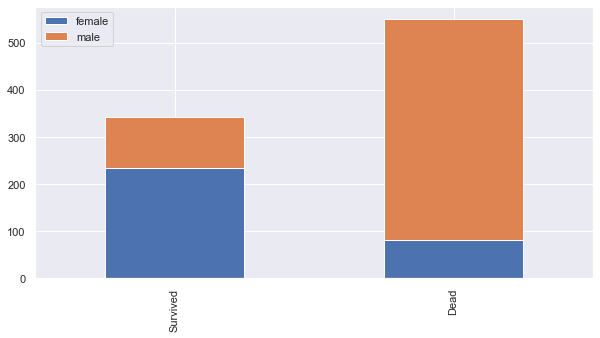

In [14]:
# 남자의 경우 많은 수가 사망했다는 사실을 알 수 있다. 

bar_chart('Sex')

In [15]:
# 2) Pclass
# 생존자 중 Pclass가 1인 사람이 많다 
# class가 내려갈 수록 생존비율이 20%씩 줄어든다.

train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

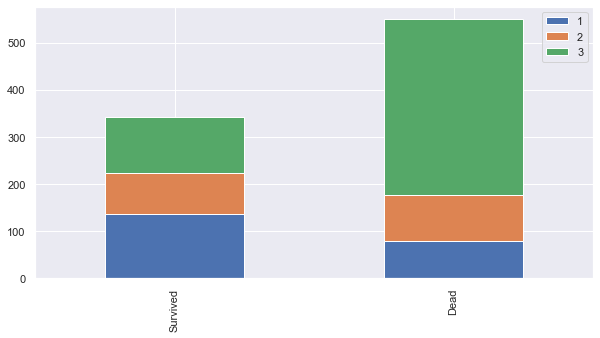

In [16]:
# 확실하게 pclass=3일 때, 사망자가 많은 것을 볼 수 있다. 

bar_chart('Pclass')

In [17]:
# 3) Embarked
# 탑승항구가 S인 사람이 제일 많았다.
# 또한 C 항구에서 탑승했을 때가 생존비율이 제일 높다. 

print(train['Embarked'].value_counts(normalize=True))
print("---------------------------------------")
print(train['Survived'].groupby(train['Embarked']).mean())

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64
---------------------------------------
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


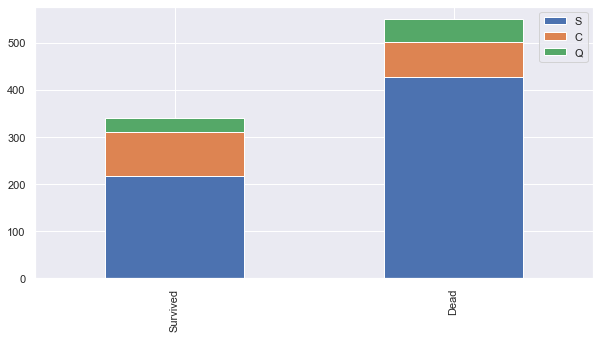

In [18]:
# S 항구에서 탑승한 승객이 사망율이 제일 높다. 

bar_chart('Embarked')

In [19]:
# 4) SibSp 
# 형제자매가 5명, 8명인 경우에는 모두 사망했다.
# 형제자매가 1~2명일 때가 생존비율이 높다. 

print(train['Survived'].groupby(train['SibSp']).mean())
print('-------------------------------')
print(train['SibSp'].value_counts())

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
-------------------------------
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64


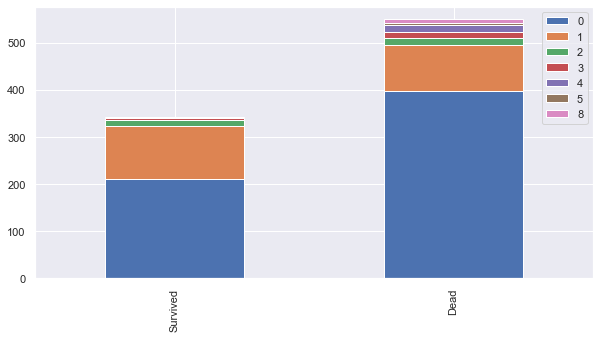

In [20]:
# 형제 자매 없이 혼자 탔을 경우 사망자가 제일 많았다. 
# 동시에 생존자도 제일 많다. 

bar_chart('SibSp')

In [21]:
# 5) Parch
# 부모, 자식이 4명, 6명일 경우 모두 사망했다.
# 부모, 자식이 1~3명인 경우 생존비율이 높았다. 

print(train['Survived'].groupby(train['Parch']).mean())
print('-------------------------------')
print(train['Parch'].value_counts())

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64
-------------------------------
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64


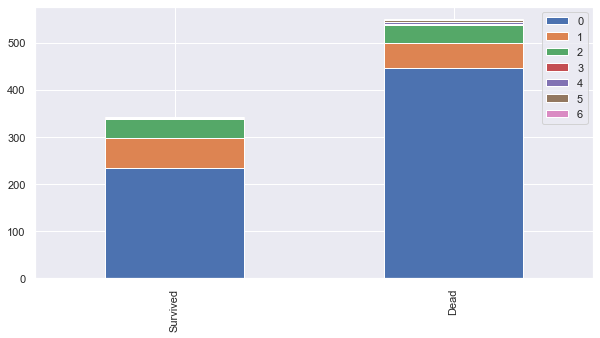

In [22]:
# Sibsp 속성과 만찬가지로 혼자 탑승한 승객인 사망자도 생존자도 제일 많다.

bar_chart('Parch')

In [23]:
# 6) Ticket
# Ticket의 맨 앞 글자만 따서 확인 

train['Ticket_Letter'] = train['Ticket'].apply(lambda x: str(x)[0])
train['Ticket_Letter'].value_counts()

3    301
2    183
1    146
S     65
P     65
C     47
A     29
W     13
4     10
7      9
F      7
6      6
L      4
5      3
8      2
9      1
Name: Ticket_Letter, dtype: int64

In [24]:
# Ticket의 맨 앞 글자 별 생존 비율
train.groupby(['Ticket_Letter'])['Survived'].mean()

Ticket_Letter
1    0.630137
2    0.464481
3    0.239203
4    0.200000
5    0.000000
6    0.166667
7    0.111111
8    0.000000
9    1.000000
A    0.068966
C    0.340426
F    0.571429
L    0.250000
P    0.646154
S    0.323077
W    0.153846
Name: Survived, dtype: float64

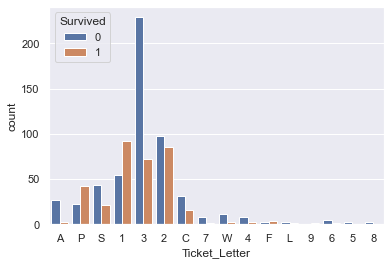

In [25]:
sns.countplot(train['Ticket_Letter'], hue=train['Survived'])

In [26]:
# 3. feature engineering 
# train, test data 결측치 파악
# age와 cabin 속성에 결측값이 많이 나온것을 확인할 수 있다. 
# train은 Embarked에서 2개의 결측값이 나왔다. 
# test는 Fare에서 1개의 결측값이 나왔다. 

print(train.isnull().sum())
print('---------------------')
print(test.isnull().sum())

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           2
Ticket_Letter      0
dtype: int64
---------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [27]:
# 1) Embarked 
# 결측치 채우기

train['Embarked'].fillna('S', inplace=True)
train['Embarked'].isnull().sum()

0

In [28]:
# train, test datad의 Embarked에 대해서 범주형 변수를 0 또는 1 값을 가지는 새로운 feature로 바꾼다.
# one-hot-encoding 진행

train = pd.get_dummies(data=train, columns=['Embarked'],prefix='Em')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket_Letter,Em_C,Em_Q,Em_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,A,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,P,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,1,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,3,0,0,1


In [29]:
test = pd.get_dummies(data=test, columns=['Embarked'],prefix='Em')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Em_C,Em_Q,Em_S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,0,0,1


In [30]:
# 2) Sex
#  train, test datad의 Sex에 대해서 범주형 변수를 0 또는 1 값을 가지는 새로운 feature로 바꾼다.
# one-hot-encoding 진행

train = pd.get_dummies(data=train, columns=['Sex'], prefix='Sex')
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket_Letter,Em_C,Em_Q,Em_S,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,A,0,0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,P,1,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,1,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,3,0,0,1,0,1


In [31]:
test = pd.get_dummies(data=test, columns=['Sex'],prefix='Sex')
test.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Em_C,Em_Q,Em_S,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,1,0,0,1
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,0,0,1,1,0


In [32]:
# 3) Pclass
#  train, test datad의 Pclass에 대해서 범주형 변수를 0 또는 1 값을 가지는 새로운 feature로 바꾼다.
# one-hot-encoding 진행

train = pd.get_dummies(data=train, columns=['Pclass'], prefix='Pclass')
train.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket_Letter,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,A,0,0,1,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,P,1,0,0,1,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1,0,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,1,1,0,1,0,0
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,3,0,0,1,0,1,0,0,1


In [33]:
test = pd.get_dummies(data=test, columns=['Pclass'], prefix='Pclass')
test.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,892,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,1,0,0,1,0,0,1
1,893,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,0,0,1,1,0,0,0,1
2,894,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,1,0,0,1,0,1,0
3,895,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,0,1,0,1,0,0,1
4,896,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,0,0,1,1,0,0,0,1


In [34]:
# 4) Name
# Name이 너무 다양하게 존재한다. 따라서 Name의 middle에 있는 호칭만 추출한다. 
for data in [train, test]:
    data['Rename']=''
    name =[]
    i = re.compile('([A-Za-z]+)\.')
    for value in data['Name']:
        name.append(i.search(value).group())
    data['Rename'] = name
    

In [35]:
# 재처리한 이름의 항목을 확인한다. 

print(train['Rename'].value_counts())
print("=============================")
print(test['Rename'].value_counts())

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Countess.      1
Capt.          1
Mme.           1
Jonkheer.      1
Lady.          1
Sir.           1
Don.           1
Ms.            1
Name: Rename, dtype: int64
Mr.        240
Miss.       78
Mrs.        72
Master.     21
Rev.         2
Col.         2
Dr.          1
Ms.          1
Dona.        1
Name: Rename, dtype: int64


In [36]:
# 당시 시대를 보았을 때, Major,Capt과 Sir은 남자임을 추측할 수 있어서 Mr로 대체한다.
# Mlle, Ms는 Miss, Mme은 Mrs로 대체한다.
# 나머지 호칭은 모르겠으므로 unkonwn 으로 대체한다.

for data in [train, test] :
    data['Rename'].replace(['Capt.','Sir.','Major.'],'Mr',inplace=True)
    data['Rename'].replace(['Mlle.','Ms.'],'Miss', inplace=True)
    data['Rename'].replace('Mme.','Mrs.', inplace=True)
    data['Rename'].replace(['Dr.','Rev.','Col.','Jonkheer.','Don.','Lady.','Countess.','Dona.'],'unkonwn', inplace=True)
    data['Rename'].replace(['Mr.','Miss.','Mrs.','Master.'],['Mr','Miss','Mrs','Master'],inplace=True)

In [37]:
# 재처리 재확인 
print(train['Rename'].value_counts())
print("=============================")
print(test['Rename'].value_counts())

Mr         521
Miss       185
Mrs        126
Master      40
unkonwn     19
Name: Rename, dtype: int64
Mr         240
Miss        79
Mrs         72
Master      21
unkonwn      6
Name: Rename, dtype: int64


In [38]:
# Rename 속성을 이용할 것이므로 Name속성을 삭제한다. 
train.drop('Name',axis=1, inplace=True)
test.drop('Name',axis=1, inplace=True)

In [39]:
#  train, test datad의 Rename에 대해서 범주형 변수를 0 또는 1 값을 가지는 새로운 feature로 바꾼다.
# one-hot-encoding 진행

train = pd.get_dummies(data=train, columns=['Rename'], prefix='Name')
train.head()

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Ticket_Letter,Em_C,...,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_unkonwn
0,1,0,22.0,1,0,A/5 21171,7.2500,NaN,A,0,...,0,1,0,0,1,0,0,1,0,0
1,2,1,38.0,1,0,PC 17599,71.2833,C85,P,1,...,1,0,1,0,0,0,0,0,1,0
2,3,1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,...,1,0,0,0,1,0,1,0,0,0
3,4,1,35.0,1,0,113803,53.1000,C123,1,0,...,1,0,1,0,0,0,0,0,1,0
4,5,0,35.0,0,0,373450,8.0500,NaN,3,0,...,0,1,0,0,1,0,0,1,0,0


In [40]:
test = pd.get_dummies(data=test, columns=['Rename'], prefix='Name')
test.head()

,PassengerId,Age,SibSp,Parch,Ticket,Fare,Cabin,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_unkonwn
0,892,34.5,0,0,330911,7.8292,NaN,0,1,0,0,1,0,0,1,0,0,1,0,0
1,893,47.0,1,0,363272,7.0000,NaN,0,0,1,1,0,0,0,1,0,0,0,1,0
2,894,62.0,0,0,240276,9.6875,NaN,0,1,0,0,1,0,1,0,0,0,1,0,0
3,895,27.0,0,0,315154,8.6625,NaN,0,0,1,0,1,0,0,1,0,0,1,0,0
4,896,22.0,1,1,3101298,12.2875,NaN,0,0,1,1,0,0,0,1,0,0,0,1,0


In [41]:
# 5) SibSp, Parch => Family size
# 위에서 보았듯이 형제 자매와 부모 자식이 없을 경우 생존율이 제일 높았다. 
# 형제 자매 SibSp와 부모 자식 Parch를 합쳐서 가족 단위로 생각해준다.

for data in [train, test]:
    
    data.loc[data['SibSp']+data['Parch']==0,'Family'] = 'Solo'
    data.loc[(data['SibSp']+data['Parch']<=3)&(data['SibSp']+data['Parch']>0),'Family'] = 'Nuclear'
    data.loc[data['SibSp']+data['Parch']>3,'Family'] = 'Big'

In [42]:
# Family 속성을 이용할 것이므로 SibSp, Parch속성을 삭제한다. 
train.drop('SibSp',axis=1, inplace=True)
test.drop('SibSp',axis=1, inplace=True)
train.drop('Parch',axis=1, inplace=True)
test.drop('Parch',axis=1, inplace=True)

In [43]:
#  train, test datad의 Family에 대해서 범주형 변수를 0 또는 1 값을 가지는 새로운 feature로 바꾼다.
# one-hot-encoding 진행

train = pd.get_dummies(data=train, columns=['Family'], prefix='Family')
train.head()

,PassengerId,Survived,Age,Ticket,Fare,Cabin,Ticket_Letter,Em_C,Em_Q,Em_S,...,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_unkonwn,Family_Big,Family_Nuclear,Family_Solo
0,1,0,22.0,A/5 21171,7.2500,NaN,A,0,0,1,...,0,1,0,0,1,0,0,0,1,0
1,2,1,38.0,PC 17599,71.2833,C85,P,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,3,1,26.0,STON/O2. 3101282,7.9250,NaN,S,0,0,1,...,0,1,0,1,0,0,0,0,0,1
3,4,1,35.0,113803,53.1000,C123,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,5,0,35.0,373450,8.0500,NaN,3,0,0,1,...,0,1,0,0,1,0,0,0,0,1


In [44]:
test = pd.get_dummies(data=test, columns=['Family'], prefix='Family')
test.head()

,PassengerId,Age,Ticket,Fare,Cabin,Em_C,Em_Q,Em_S,Sex_female,Sex_male,...,Pclass_2,Pclass_3,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Name_unkonwn,Family_Big,Family_Nuclear,Family_Solo
0,892,34.5,330911,7.8292,NaN,0,1,0,0,1,...,0,1,0,0,1,0,0,0,0,1
1,893,47.0,363272,7.0000,NaN,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
2,894,62.0,240276,9.6875,NaN,0,1,0,0,1,...,1,0,0,0,1,0,0,0,0,1
3,895,27.0,315154,8.6625,NaN,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
4,896,22.0,3101298,12.2875,NaN,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0


In [45]:
# 6) Age
# Age 결측치 채우기 - 평균값으로 채운다

train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)

In [46]:
# Age는 continous 자료다. 범위를 나눠서 group 번호로 다시 지정했다. 

for data in [train, test]:
    
    data.loc[data['Age'] <= 16,'Age'] = 0
    data.loc[(data['Age'] > 16)&(data['Age']<=32),'Age'] = 1
    data.loc[(data['Age'] > 32)&(data['Age']<=48),'Age'] = 2
    data.loc[(data['Age'] > 48)&(data['Age']<=64),'Age'] = 3
    data.loc[data['Age'] > 64,'Age'] = 4

train['Age']= train['Age'].astype(int)
test['Age']= test['Age'].astype(int)

In [47]:
#  train, test datad의 Age에 대해서 범주형 변수를 0 또는 1 값을 가지는 새로운 feature로 바꾼다.
# one-hot-encoding 진행

train = pd.get_dummies(data=train, columns=['Age'], prefix='Age')
train.head()

,PassengerId,Survived,Ticket,Fare,Cabin,Ticket_Letter,Em_C,Em_Q,Em_S,Sex_female,...,Name_Mrs,Name_unkonwn,Family_Big,Family_Nuclear,Family_Solo,Age_0,Age_1,Age_2,Age_3,Age_4
0,1,0,A/5 21171,7.2500,NaN,A,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,2,1,PC 17599,71.2833,C85,P,1,0,0,1,...,1,0,0,1,0,0,0,1,0,0
2,3,1,STON/O2. 3101282,7.9250,NaN,S,0,0,1,1,...,0,0,0,0,1,0,1,0,0,0
3,4,1,113803,53.1000,C123,1,0,0,1,1,...,1,0,0,1,0,0,0,1,0,0
4,5,0,373450,8.0500,NaN,3,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


In [48]:
test = pd.get_dummies(data=test, columns=['Age'], prefix='Age')
test.head()

,PassengerId,Ticket,Fare,Cabin,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,...,Name_Mrs,Name_unkonwn,Family_Big,Family_Nuclear,Family_Solo,Age_0,Age_1,Age_2,Age_3,Age_4
0,892,330911,7.8292,NaN,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,893,363272,7.0000,NaN,0,0,1,1,0,0,...,1,0,0,1,0,0,0,1,0,0
2,894,240276,9.6875,NaN,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,895,315154,8.6625,NaN,0,0,1,0,1,0,...,0,0,0,0,1,0,1,0,0,0
4,896,3101298,12.2875,NaN,0,0,1,1,0,0,...,1,0,0,1,0,0,1,0,0,0


In [49]:
# 7) Fare
# Fare 결측치 채우기 
test['Fare'].fillna(test['Fare'].median(),inplace=True)

In [50]:
# Fare는 qcut을 이용해 4개의 범위로 나눠서 group을 지어 번호를 지정했다. 

train['Fare']= pd.qcut(train['Fare'], 4, labels=[1,2,3,4])
test['Fare']= pd.qcut(test['Fare'], 4, labels=[1,2,3,4])

In [51]:
#  train, test datad의 Fare에 대해서 범주형 변수를 0 또는 1 값을 가지는 새로운 feature로 바꾼다.
# one-hot-encoding 진행

train = pd.get_dummies(data=train, columns=['Fare'], prefix='Fare')
train.head()

,PassengerId,Survived,Ticket,Cabin,Ticket_Letter,Em_C,Em_Q,Em_S,Sex_female,Sex_male,...,Family_Solo,Age_0,Age_1,Age_2,Age_3,Age_4,Fare_1,Fare_2,Fare_3,Fare_4
0,1,0,A/5 21171,NaN,A,0,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
1,2,1,PC 17599,C85,P,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,3,1,STON/O2. 3101282,NaN,S,0,0,1,1,0,...,1,0,1,0,0,0,0,1,0,0
3,4,1,113803,C123,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
4,5,0,373450,NaN,3,0,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0


In [52]:
test = pd.get_dummies(data=test, columns=['Fare'], prefix='Fare')
test.head()

,PassengerId,Ticket,Cabin,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,Pclass_2,...,Family_Solo,Age_0,Age_1,Age_2,Age_3,Age_4,Fare_1,Fare_2,Fare_3,Fare_4
0,892,330911,NaN,0,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
1,893,363272,NaN,0,0,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,894,240276,NaN,0,1,0,0,1,0,1,...,1,0,0,0,1,0,0,1,0,0
3,895,315154,NaN,0,0,1,0,1,0,0,...,1,0,1,0,0,0,0,1,0,0
4,896,3101298,NaN,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [53]:
# 8) Ticket
# '1', '2', '3', 'S', 'P', 'C', 'A' : 20개 이상을 가지고 있는 Ticket들은 각 Ticket의 앞 문자에 맞게 지정해준다.
# 'F','W', '4', '7', '6' : Low_ticket, 나머지는 Other_ticket으로 구분 

 for data in [train, test]:
        data['Ticket_Letter'] = data['Ticket'].apply(lambda x: str(x)[0])
        data['Ticket_Letter'] = data['Ticket_Letter'].apply(lambda x: str(x))
        data['Ticket_Letter'] = np.where((data['Ticket_Letter']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), data['Ticket_Letter'],
                                   np.where((data['Ticket_Letter']).isin(['F','W', '4', '7', '6']),
                                            'Low_ticket', 'Other_ticket'))

In [54]:
# Ticket_Letter 속성을 이용할 것이므로 Ticket 속성을 삭제한다. 
train.drop('Ticket',axis=1, inplace=True)
test.drop('Ticket',axis=1, inplace=True)

In [55]:
#  train, test datad의 Ticket_Letter에 대해서 범주형 변수를 0 또는 1 값을 가지는 새로운 feature로 바꾼다.
# one-hot-encoding 진행

train = pd.get_dummies(data=train, columns=['Ticket_Letter'], prefix='Ticket')
train.head()

,PassengerId,Survived,Cabin,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,Pclass_2,...,Fare_4,Ticket_1,Ticket_2,Ticket_3,Ticket_A,Ticket_C,Ticket_Low_ticket,Ticket_Other_ticket,Ticket_P,Ticket_S
0,1,0,NaN,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2,1,C85,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,1,0
2,3,1,NaN,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,1,C123,0,0,1,1,0,1,0,...,1,1,0,0,0,0,0,0,0,0
4,5,0,NaN,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [56]:
test = pd.get_dummies(data=test, columns=['Ticket_Letter'], prefix='Ticket')
test.head()

,PassengerId,Cabin,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,...,Fare_4,Ticket_1,Ticket_2,Ticket_3,Ticket_A,Ticket_C,Ticket_Low_ticket,Ticket_Other_ticket,Ticket_P,Ticket_S
0,892,NaN,0,1,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,893,NaN,0,0,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,894,NaN,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,895,NaN,0,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,896,NaN,0,0,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [57]:
# 9) Cabin, PassengerID
# Cabin 속성은 거의 70 %이상이 결측값이므로 해당 속성은 train, test에서 제외한다.
# PassengerID도 삭제한다.

train.drop('Cabin',axis=1, inplace=True)
test.drop('Cabin',axis=1, inplace=True)
train.drop('PassengerId',axis=1, inplace=True)
test.drop('PassengerId',axis=1, inplace=True)

In [58]:
# train과 test에 대해서 결측값 전부 제거 되었는지 확인
print(train.isnull().sum())
print("-------------------------------")
print(test.isnull().sum())

Survived               0
Em_C                   0
Em_Q                   0
Em_S                   0
Sex_female             0
Sex_male               0
Pclass_1               0
Pclass_2               0
Pclass_3               0
Name_Master            0
Name_Miss              0
Name_Mr                0
Name_Mrs               0
Name_unkonwn           0
Family_Big             0
Family_Nuclear         0
Family_Solo            0
Age_0                  0
Age_1                  0
Age_2                  0
Age_3                  0
Age_4                  0
Fare_1                 0
Fare_2                 0
Fare_3                 0
Fare_4                 0
Ticket_1               0
Ticket_2               0
Ticket_3               0
Ticket_A               0
Ticket_C               0
Ticket_Low_ticket      0
Ticket_Other_ticket    0
Ticket_P               0
Ticket_S               0
dtype: int64
-------------------------------
Em_C                   0
Em_Q                   0
Em_S                   0
Sex_f

In [59]:
train.head()

,Survived,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Name_Master,...,Fare_4,Ticket_1,Ticket_2,Ticket_3,Ticket_A,Ticket_C,Ticket_Low_ticket,Ticket_Other_ticket,Ticket_P,Ticket_S
0,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,1,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [60]:
test.head()

,Em_C,Em_Q,Em_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Name_Master,Name_Miss,...,Fare_4,Ticket_1,Ticket_2,Ticket_3,Ticket_A,Ticket_C,Ticket_Low_ticket,Ticket_Other_ticket,Ticket_P,Ticket_S
0,0,1,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [61]:
# 3. 데이터 셋 분리

x_train = train.drop('Survived',axis=1)
y_train = train['Survived']
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((623, 34), (623,), (268, 34), (268,))

In [63]:
# 4. 모델 생성
RFC = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)

RFC.fit(x_train, y_train)

print(RFC.score(x_train, y_train))
print(RFC.score(x_test, y_test))

test_pred = RFC.predict(test)

submission = pd.DataFrame({
    "PassengerId": sub,
    "Survived" : test_pred
})

submission.to_csv('titanic_RFC.csv', index = False)

0.884430176565008
0.8208955223880597


In [64]:
# 4. 모델 생성
svc = SVC()
svc.fit(x_train, y_train)

print(svc.score(x_train, y_train))
print(svc.score(x_test, y_test))

test_pred = svc.predict(test)

submission = pd.DataFrame({
    "PassengerId": sub,
    "Survived" : test_pred
})

submission.to_csv('titanic_SVC.csv', index = False)

0.85553772070626
0.832089552238806
